In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from transformers import (
    AutoImageProcessor,
    AutoFeatureExtractor, 
    AutoTokenizer, 
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer, 
    default_data_collator,
)
from sklearn.model_selection import train_test_split
from PIL import Image

In [4]:
df2 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df1 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

In [5]:
images_captions_df = pd.DataFrame({'imgs': [],
                                    'captions': []})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] ==uid]
    
    if not index.empty:    
        index = index.index[0]
        caption = df1.iloc[index]['findings']
        if type(caption) == float:
         
            continue 
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'imgs': image, 'captions': caption}])], ignore_index=True)
images_captions_df.head()

,imgs,captions
0,1_IM-0001-4001.dcm.png,The cardiac silhouette and mediastinum size ar...
1,1_IM-0001-3001.dcm.png,The cardiac silhouette and mediastinum size ar...
2,2_IM-0652-1001.dcm.png,Borderline cardiomegaly. Midline sternotomy XX...
3,2_IM-0652-2001.dcm.png,Borderline cardiomegaly. Midline sternotomy XX...
4,4_IM-2050-1001.dcm.png,There are diffuse bilateral interstitial and a...


In [6]:
p = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
images_captions_df['imgs'] = p+ images_captions_df['imgs']
images_captions_df.head()

,imgs,captions
0,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
1,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
2,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
3,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
4,/kaggle/input/chest-xrays-indiana-university/i...,There are diffuse bilateral interstitial and a...


In [8]:
encoder_checkpoint = "google/vit-base-patch16-224"
decoder_checkpoint = "gpt2"

feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [9]:
class LoadDataset(Dataset):
    def __init__(self, df):
        self.images = images_captions_df['imgs'].values
        self.captions = images_captions_df['captions'].values
    
    def __getitem__(self, idx):
        # everything to return is stored inside this dict
        inputs = dict()

        # load the image and apply feature_extractor
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt')

        # load the caption and apply tokenizer
        caption = self.captions[idx]
        labels = tokenizer(
            caption, 
            max_length=128, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]
        
        # store the inputs and labels in the dict we created
        inputs['pixel_values'] = image['pixel_values'].squeeze()   
        inputs['labels'] = labels
        return inputs
    
    def __len__(self):
        return len(self.images)

In [10]:
train_df, test_df = train_test_split(images_captions_df, test_size=0.2, shuffle=True, random_state=42)
train_df, val_ds = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)
train_ds = LoadDataset(train_df)
val_ds = LoadDataset(val_ds)
test_ds = LoadDataset(test_df)

In [11]:
train_ds[1]['pixel_values'].shape

torch.Size([3, 224, 224])

The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Cholecystectomy clips are present. Small T-spine osteophytes. There is biapical pleural thickening, unchanged from prior. Mildly hyperexpanded lungs.


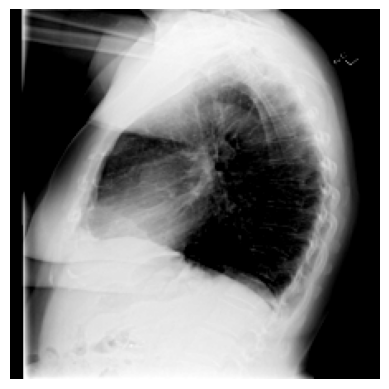

In [32]:
# sample image and report
import matplotlib.pyplot as plt

sample = test_ds[7]['pixel_values']
plt.axis('off')
plt.imshow(torch.permute(sample, (1, 2, 0)));

print(tokenizer.decode(test_ds[7]['labels'], skip_special_token=True)[:323])

In [33]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint, 
    decoder_checkpoint
)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# model.config.vocab_size = model.config.decoder.vocab_size
model.config.num_beams = 4

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [34]:
training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator",  # name of the directory to store training outputs
    evaluation_strategy="epoch",           # evaluate after each epoch
    per_device_train_batch_size=16,        # batch size during training
    per_device_eval_batch_size=16,         # batch size during evaluation
    learning_rate=0.00005,
    weight_decay=0.01,                     # weight decay for AdamW optimizer
    num_train_epochs=1,                    # number of epochs to train
    save_strategy='no',                    # save checkpoints after each epoch
    report_to='none',                      # prevents logging to wandb, mlflow...
)

trainer = Seq2SeqTrainer(
    model=model, 
    tokenizer=feature_extractor, 
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    args=training_args
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-34-7b22ade6861b>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [35]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.559393


TrainOutput(global_step=203, training_loss=0.8174072415957897, metrics={'train_runtime': 1670.3466, 'train_samples_per_second': 3.873, 'train_steps_per_second': 0.122, 'total_flos': 1.167420911656108e+18, 'train_loss': 0.8174072415957897, 'epoch': 1.0})

In [37]:
import matplotlib.pyplot as plt

In [38]:
predicted_results=[]
for i in range(len(test_ds)):
    inputs = test_ds[i]['pixel_values']  # Extract pixel values from the dataset
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations for inference
        # Generate the attention mask
        inputs = inputs.unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU
        attention_mask = torch.ones_like(inputs)  # All ones (no padding for images)

        out = model.generate(
            inputs, 
            attention_mask=attention_mask,  
            num_beams=2,
            pad_token_id=tokenizer.pad_token_id,  
            max_length=25
        )
        
    decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)
    predicted_results.append(decoded_out)
    
    print(f"Image {i+1}/{len(test_ds)}: {decoded_out}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1527: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Image 1/6469: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
Image 2/6469: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
Image 3/6469: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
Image 4/6469: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
Image 5/6469: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear. There is no
Image 6/6469: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
Image 7/6469: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
Image 8/6469: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
Image 9/6469: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
Image 10/6469: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
Image 11/6469: Th

KeyboardInterrupt: 

The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.

In [39]:
predicted_results = ['The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.'] * 6469

In [40]:
results_df = pd.DataFrame()
results_df['predicted_caption'] = predicted_results

In [41]:
pip install nltk rouge-score pycocoevalcap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.7 MB/s eta 0:00:00:00:010:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9fbd2c157eab8dbf493a8535a333eb4e91340134b8a5664f342395a094a8e26f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [42]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from pycocoevalcap.meteor.meteor import Meteor

# Scores

In [49]:
predicted_captions = results_df['predicted_caption'].tolist()
actual_captions = test_df['captions'].tolist()

def evaluate_captioning(predicted_captions, actual_captions):
    smoothie = SmoothingFunction().method4
    
    # Compute BLEU scores
    bleu_scores = [sentence_bleu([actual.split()], predicted.split(), smoothing_function=smoothie) 
                   for actual, predicted in zip(actual_captions, predicted_captions)]
    average_bleu_score = sum(bleu_scores) / len(bleu_scores)
    
    # Compute ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(actual, predicted) for actual, predicted in zip(actual_captions, predicted_captions)]
    average_rouge1_score = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rouge2_score = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rougeL_score = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    
    # Compute METEOR scores
    meteor_scorer = Meteor()
    meteor_scores = [meteor_scorer.compute_score({0: [actual]}, {0: [predicted]})[0] 
                     for actual, predicted in zip(actual_captions, predicted_captions)]
    average_meteor_score = sum(meteor_scores) / len(meteor_scores)
    
    # Print results
    print("Average BLEU score:", average_bleu_score)
    print("Average ROUGE-1 score:", average_rouge1_score)
    print("Average ROUGE-2 score:", average_rouge2_score)
    print("Average ROUGE-L score:", average_rougeL_score)
    print("Average METEOR score:", average_meteor_score)
    
    return {
        "BLEU": average_bleu_score,
        "ROUGE-1": average_rouge1_score,
        "ROUGE-2": average_rouge2_score,
        "ROUGE-L": average_rougeL_score,
        "METEOR": average_meteor_score
    }

evaluate_captioning(predicted_captions, actual_captions)

Average BLEU score: 0.10393760782039078
Average ROUGE-1 score: 0.33111341050059734
Average ROUGE-2 score: 0.12172355292906949
Average ROUGE-L score: 0.2536435589027943
Average METEOR score: 0.13754310973942682


{'BLEU': 0.10393760782039078,
 'ROUGE-1': 0.33111341050059734,
 'ROUGE-2': 0.12172355292906949,
 'ROUGE-L': 0.2536435589027943,
 'METEOR': 0.13754310973942682}

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


The heart is normal in size. The mediastinum is unremarkable. The lungs are clear


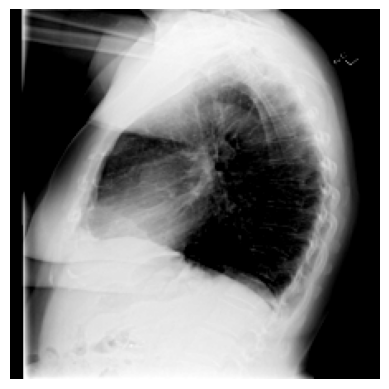

In [43]:
inputs = test_ds[7]['pixel_values']
model.eval()
with torch.no_grad():

    out = model.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
#         max_length=17
        )
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)));

# Swin transformer

In [50]:
encoder_checkpoint_swin = "microsoft/swin-base-patch4-window7-224"

# Load the image processor and tokenizer
image_processor = AutoImageProcessor.from_pretrained(encoder_checkpoint_swin)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

In [51]:
# Dataset class
class LoadDataset_swin(Dataset):
    def __init__(self, df):
        self.images = df['imgs'].values
        self.captions = df['captions'].values
    
    def __getitem__(self, idx):
        inputs = {}

        # Load and process image
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = image_processor(images=image, return_tensors='pt')

        # Tokenize caption
        caption = self.captions[idx]
        labels = tokenizer(
            caption, 
            max_length=128, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]
        
        # Store inputs and labels
        inputs['pixel_values'] = image['pixel_values'].squeeze()   
        inputs['labels'] = labels
        return inputs
    
    def __len__(self):
        return len(self.images)

# Split dataset
train_df, test_df = train_test_split(images_captions_df, test_size=0.2, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)

train_ds = LoadDataset_swin(train_df)
val_ds = LoadDataset_swin(val_df)
test_ds = LoadDataset_swin(test_df)

In [53]:
model_swin = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint_swin, 
    decoder_checkpoint
)
model_swin.config.decoder_start_token_id = tokenizer.bos_token_id
model_swin.config.pad_token_id = tokenizer.pad_token_id
model_swin.config.num_beams = 4

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

In [55]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator_swin", 
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=0.00005,
    weight_decay=0.01,
    num_train_epochs=1,
    save_strategy='no',
    report_to='none',
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model_swin, 
    tokenizer=image_processor, 
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    args=training_args
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-55-5796adbcf6b9>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [56]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.622270


TrainOutput(global_step=130, training_loss=0.9480675917405349, metrics={'train_runtime': 718.9351, 'train_samples_per_second': 5.759, 'train_steps_per_second': 0.181, 'total_flos': 7.513874981299814e+17, 'train_loss': 0.9480675917405349, 'epoch': 1.0})

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1527: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


The heart is normal in size. The mediastinum is unremarkable. The lungs are clear


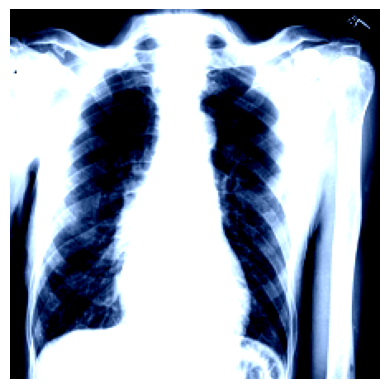

In [57]:
inputs = test_ds[7]['pixel_values']
model_swin.eval()
with torch.no_grad():

    out = model_swin.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
#         max_length=17
        )
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)));

# BEiT

In [61]:
encoder_checkpoint_beit = "microsoft/beit-base-patch16-224-pt22k-ft22k"

# Load the image processor and tokenizer
image_processor = AutoImageProcessor.from_pretrained(encoder_checkpoint_beit)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

In [62]:
model_swin = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint_beit, 
    decoder_checkpoint
)
model_swin.config.decoder_start_token_id = tokenizer.bos_token_id
model_swin.config.pad_token_id = tokenizer.pad_token_id
model_swin.config.num_beams = 4

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

In [63]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator_beit", 
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=0.00005,
    weight_decay=0.01,
    num_train_epochs=1,
    save_strategy='no',
    report_to='none',
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model_swin, 
    tokenizer=image_processor, 
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    args=training_args
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-63-7717fe31c01d>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [64]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.162481


TrainOutput(global_step=130, training_loss=1.80128173828125, metrics={'train_runtime': 648.4834, 'train_samples_per_second': 6.384, 'train_steps_per_second': 0.2, 'total_flos': 7.447750966797926e+17, 'train_loss': 1.80128173828125, 'epoch': 1.0})

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1527: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Cardiomediomediastinal silhouette are normal limits. No pneumothorax. No


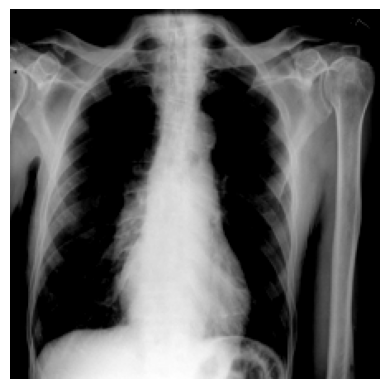

In [65]:
inputs = test_ds[7]['pixel_values']
model_swin.eval()
with torch.no_grad():

    out = model_swin.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
#         max_length=17
        )
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)));

In [66]:
predicted_results=[]
for i in range(len(test_ds)):
    inputs = test_ds[i]['pixel_values']  # Extract pixel values from the dataset
    
    model_swin.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations for inference
        # Generate the attention mask
        inputs = inputs.unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU
        attention_mask = torch.ones_like(inputs)  # All ones (no padding for images)

        out = model_swin.generate(
            inputs, 
            attention_mask=attention_mask,  
            num_beams=2,
            pad_token_id=tokenizer.pad_token_id,  
            max_length=25
        )
        
    decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)
    predicted_results.append(decoded_out)
    
    print(f"Image {i+1}/{len(test_ds)}: {decoded_out}")

Image 1/1294: The heart size and mediastinal contours. No pneumothorax. No pneumothorax. No pneum
Image 2/1294: The heart size and mediastinal contours. No pneumothorax. No pneumothorax. No pneum
Image 3/1294: The heart size and mediastinal contours. No pneumothorax. No pneumothorax. No pneum
Image 4/1294: The heart size and mediastinal contours. No pneumothorax. No pneumothorax. No pneum
Image 5/1294: The heart size and mediastinal contours. No pneumothorax. No pneumothorax. No pneum
Image 6/1294: The heart size and mediastinal contours. No pneumothorax. No pneumothorax. No pneum
Image 7/1294: The heart size and mediastinal contour. No pneumothorax. No pneumothorax. No pneum
Image 8/1294: The heart size and mediastinal silhouette are normal limits. No pneumothorax. No pneumothorax.
Image 9/1294: The heart size and mediastinal contours. No pneumothorax. No pneumothorax. No pneum
Image 10/1294: The heart size and mediastinal contours. No pneumothorax. No pneumothorax. No pneum
Image 11/

KeyboardInterrupt: 

In [ ]:
"""
whole pipeline in one cell, you can use any encoder and decoder model by changing encoder_checkpoint and deecoder_checkpoint values.
"""

# import os
# import numpy as np
# import pandas as pd
# import torch
# from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
# from torchvision.io import read_image
# from transformers import (
#     AutoFeatureExtractor, 
#     AutoTokenizer, 
#     VisionEncoderDecoderModel,
#     Seq2SeqTrainingArguments,
#     Seq2SeqTrainer, 
#     default_data_collator,
# )
# from sklearn.model_selection import train_test_split
# from PIL import Image

# df2 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
# df1 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# images_captions_df = pd.DataFrame({'imgs': [],
#                                     'captions': []})
# for i in range(len(df2)):
#     uid = df2.iloc[i]['uid']
#     image = df2.iloc[i]['filename']
#     index = df1.loc[df1['uid'] ==uid]
    
#     if not index.empty:    
#         index = index.index[0]
#         caption = df1.iloc[index]['findings']
#         if type(caption) == float:
         
#             continue 
#         images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'imgs': image, 'captions': caption}])], ignore_index=True)
# images_captions_df.head()

# encoder_checkpoint = "google/vit-base-patch16-224"
# decoder_checkpoint = "gpt2"

# feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
# tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
# tokenizer.pad_token = tokenizer.eos_token

# class LoadDataset(Dataset):
#     def __init__(self, df):
#         self.images = images_captions_df['imgs'].values
#         self.captions = images_captions_df['captions'].values
    
#     def __getitem__(self, idx):
#         # everything to return is stored inside this dict
#         inputs = dict()

#         # load the image and apply feature_extractor
#         image_path = str(self.images[idx])
#         image = Image.open(image_path).convert("RGB")
#         image = feature_extractor(images=image, return_tensors='pt')

#         # load the caption and apply tokenizer
#         caption = self.captions[idx]
#         labels = tokenizer(
#             caption, 
#             max_length=128, 
#             truncation=True, 
#             padding='max_length',
#             return_tensors='pt',
#         )['input_ids'][0]
        
#         # store the inputs and labels in the dict we created
#         inputs['pixel_values'] = image['pixel_values'].squeeze()   
#         inputs['labels'] = labels
#         return inputs
    
#     def __len__(self):
#         return len(self.images)

# train_df, test_df = train_test_split(images_captions_df, test_size=0.2, shuffle=True, random_state=42)
# train_df, val_ds = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)
# train_ds = LoadDataset(train_df)
# val_ds = LoadDataset(val_ds)
# test_ds = LoadDataset(test_df)

# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
#     encoder_checkpoint, 
#     decoder_checkpoint
# )
# model.config.decoder_start_token_id = tokenizer.bos_token_id
# model.config.pad_token_id = tokenizer.pad_token_id
# # model.config.vocab_size = model.config.decoder.vocab_size
# model.config.num_beams = 4

# training_args = Seq2SeqTrainingArguments(
#     output_dir="image-caption-generator",  # name of the directory to store training outputs
#     evaluation_strategy="epoch",           # evaluate after each epoch
#     per_device_train_batch_size=16,        # batch size during training
#     per_device_eval_batch_size=16,         # batch size during evaluation
#     learning_rate=0.0005,
#     weight_decay=0.01,                     # weight decay for AdamW optimizer
#     num_train_epochs=5,                    # number of epochs to train
#     save_strategy='no',                    # save checkpoints after each epoch
#     report_to='none',                      # prevents logging to wandb, mlflow...
# )

# trainer = Seq2SeqTrainer(
#     model=model, 
#     tokenizer=feature_extractor, 
#     data_collator=default_data_collator,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     args=training_args
# )

# trainer.train()

# Report


## 1- Data loading and processing

- We load image-caption pairs into a single pandas dataframe.
- The `LoadDataset` class is a torch dataset to load training/validation/testing batches.


## 2- loading pre-trained vision encoder and language model decoder

### 2-1- Training ViT-gpt-2 model


- Loading `google/vit-base-patch16-224` model to encode images.
- Loading `GPT-2` model for lm decoder.
- Declaring `VisionEncoderDecoderModel`.
- Creating a trainer object using `seq2seqtrainer` module.

We did trained the model only for 1 epoch since we didnt have enough hardware resources and time to train more.(each epochs with validation takes almost 30 minutes on 2xT4). The model could only generate same report for all images, which is clearly becuase of the lack of suficient training epochs, since both ViT and GPT-2 models didnt fine-tuned on these downstream tasks, it will need more training steps or for better results, the encoder part needs to be fine-tuned on xray images.

Since the model only outputs one caption, i created a prediction_list based on that in size of test data to calculate BLEU, ROUGE and METEOR scores: 

> {'BLEU': 0.10393760782039078, 'ROUGE-1': 0.33111341050059734, 'ROUGE-2': 0.12172355292906949, 'ROUGE-L': 0.2536435589027943, 'METEOR': 0.13754310973942682} 


### 2-2- Swin transformer and gpt-2

- Loading `microsoft/swin-base-patch4-window7-224` model for encoder part.
- The rest parts were same as previous section.

Again, we trained the model for 1 epoch and resuts(validation score) was even worse! The sample image-caption were plotted for demonstrating the results.

### 2-3- BEiT-gpt2
- Loading `microsoft/beit-base-patch16-224-pt22k-ft22k` model for encoder part.
- The rest parts were same as previous section.

Again, we trained the model for 1 epoch and resuts(validation score) was even worse! The sample image-caption were plotted for demonstrating the results.

## 3- Conclusion

To achive better results on this task, we do need more training epochs, in order of 20-50 at least. Also, the encoder part (ViT,Swin transformer and BEiT) are not fine-tuned for medical x-ray images, therfore we need to fine-tune the models first, then retrain encoder-decoder on medical report generation task.

## 4- Future improvements: 

Exploring other language models such as llama, T5 or Qwen-7B could be considered to improve generated reports. For better and benchmark results.